## Import Libraries

In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import time
import random
import math
from datetime import datetime
from collections import deque 
from matplotlib.pyplot import figure
import seaborn as sns

In [ ]:
# Mount Drive
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/ADM_HW5/DATA'

import os
os.chdir(path)

# 1. Data

First of all, we are going to deal with our data. We are going to load each file as a DataFrame with columns corresponding to the source node, the arrival node and the date of the interaction.

In [ ]:
A = pd.read_csv('sx-stackoverflow-a2q.txt', sep = ' ', names = ['node1', 'node2', 'date'])
B = pd.read_csv('sx-stackoverflow-c2a.txt', sep = ' ', names = ['node1', 'node2', 'date'])
C = pd.read_csv('sx-stackoverflow-c2q.txt', sep = ' ', names = ['node1', 'node2', 'date'])

After that, we are going to define functions that will help us merge the dataframes together and filter them according to a specified interval of time (we have rounded up all dates to the corresponding day, discarding hours, minutes and seconds). After merging and filtering, the function transforms the dataframe into a graph. We have decided to give a weight to the edges based on the type of the interaction: since an answer is intituitevely more important than a comment, we are going to give a weight = 1 to the answers to questions and a weight = 0.5 to both the comments to answers and comments to questions. The weight of the edge between two users is given by the sum of the different weights of the interactions they had during the specified period of time.

In [ ]:
def filter_data(data, start='01-01-1970', end='01-01-1971'):
    ''' Function to filter joined dataframe of all three graphs given an interval of time. Valid input is in the form DD-MM-YYYY. '''
    # check validity of input
    try:
        # convert input dates to timestamp
        converted_start = int(time.mktime(datetime.strptime(start, "%d-%m-%Y").timetuple()))
        converted_end = int(time.mktime(datetime.strptime(end, "%d-%m-%Y").timetuple()))
        # filter dataset
        filtered = data.loc[ (data['date'] > converted_start) & (data['date'] < converted_end), data.columns[:]]
        return filtered  
    # raise an exception if input is not valid
    except:
        print('Invalid Input!') 

In [ ]:
def create_graph(start = None, end = None,data1 = A, data2 = B, data3 = C):
    ''' Merges single dataframes into a single graph. '''
    # adding weight columns to each dataframe
    data1['weight'] = 1
    data2['weight'] = 0.5
    data3['weight'] = 0.5
    # merging into a single dataframe
    merged = pd.concat([data1, data2, data3])
    # asking user for interval of time
    if not start or not end:
        start = input('Enter start date')
        end = input('Enter end date')
    # filtering based on dates
    filtered = filter_data(merged, start, end)
    # compute total weight of each edge
    filtered['weight'] = filtered.groupby(['node1', 'node2'])['weight'].transform(sum)
    # create graph
    G = nx.from_pandas_edgelist(filtered, 'node1', 'node2',
                            create_using=nx.DiGraph(), edge_attr=['weight', 'date'])
    return G

Let's try it out!

In [ ]:
graph = create_graph("06-01-2010","07-01-2010")

In [ ]:
nx.info(graph)

'DiGraph with 4638 nodes and 8739 edges'

# 2. Implementation of the backend

## Functionality 1 - Get the overall features of the graph

In [ ]:
def directed(g) :
  for u, neigh in g._adj.items():
    for n in neigh:
      #print("u", u, "neigh:", neigh)
      if n != u and not ([(node,w) for node,w in g._adj[n] if (node==u and w==n)]):
        return True
      return False

def users_num(g):
  return len(g)

def c_a_num(g):
  return len(graph.edges)

def avg_c_a(g):
  return c_a_num(g)/users_num(g)

def DensityDegree(g):
  return c_a_num(g) / users_num(g)**2

def sparse_density(g):
    if users_num(g) / c_a_num(g)**2 < 10:
        return 'graph is sparse'
    else:
        return 'graph is dense'

#### Whether the graph is directed or not

In [ ]:
directed(graph)

True

#### Number of users

In [ ]:
users_num(graph)

4638

#### Number of answers/comments

In [ ]:
c_a_num(graph)

8739

#### Average number of links per user

In [ ]:
avg_c_a(graph)

1.8842173350582148

#### Density degree of the graph

In [ ]:
DensityDegree(graph)

0.00040625643274217653

#### Density degree of the graph

In [ ]:
sparse_density(graph)

'graph is sparse'

## Functionality 2 - Find the best users

In order to deal with the computation of the specified metrics, we are going to define some functions that will help us find shortest paths between nodes. All the functions are essentially based on Dijkstra's Algorithm, but have slight variations based on what is needed to compute the metric:
- function <b>dijkstra</b> : returns a dictionary of all distances between a given node and all other nodes in the graph
- function <b>dijsktra_shortest</b>: returns the shortest path - as a list of edges - (considering the weight of the edges) between two nodes in the graph
- function <b>dijsktra_all_shortest</b>: given two nodes in a graph, returns the number of shortest paths (considering their weight) between them.


By combining all of the three, we are going to define a function for each of the metrics, which we are going to use to define the second functionality.

In [ ]:
def dijkstra(graph, node):
    ''' Computes the shortest distance between a node and all other nodes in a graph using Dijkstra's algorithm. '''
    visited = []
    # initializing dictionary to store distances
    distances = {n : float('inf') for n in graph.nodes}
    # setting distance from starting node to 0
    distances[node] = 0
    # initializing the queue and enqueuing starting node
    queue = []
    queue.append((0, node))
    while queue:
        # dequeueing
        current = queue.pop()[1]
        # mark as visited
        visited.append(current)
        # iterate over neighbors
        for neighbor in graph.neighbors(current):
            # finding distance between current node and current neighbor (weight is considered as distance)
            distance = graph.edges[current, neighbor]['weight']
            if neighbor not in visited:
                # check if it's necessary to update the distance (only if the new one is smaller)
                old = distances[neighbor]
                new = distances[current] + distance
                if new < old:
                    queue.insert(0, (new,neighbor))
                    distances[neighbor] = new
    return distances

In [ ]:
def reconstruct_path(paths, start, end):
    '''Given the dictionary containing shortest paths, reconstructs the whole paths between start and end nodes.'''
    res = []
    if not paths[end][0]:
        return res
    res.append(end)
    current = end
    while current != start:
        previous = paths[current][0]
        res.append(previous)
        current = previous
    return res[::-1]

def dijkstra_shortest(graph, start, end):
    '''Variation of Dijkstra's algorithm to find the nodes in the shortest path between two nodes.'''
    # initializing dictionary to store all paths
    paths = {start : (None, 0)}
    current = start
    visited = set()
    # while on the path
    while current != end:
        # mark as visited
        visited.add(current)
        neighbors = graph.neighbors(current)
        # checking if a path exists
        if not neighbors:
            print('No path!')
        dist = paths[current][1]
        for neighbor in neighbors:
            # computing distance between current node and current neighbor (weight is considered as distance)
            distance = graph.edges[current, neighbor]['weight'] + dist
            # saving results
            if neighbor not in paths:
                paths[neighbor] = (current, distance)
            else:
                old = paths[neighbor][1]
                if old > distance:
                    paths[neighbor] = (current, distance)
        to_visit_next = {node: paths[node] for node in paths if node not in visited}
        if not to_visit_next:
            return []
        # next node is the closest
        current = min(to_visit_next, key=lambda x: to_visit_next[x][1])
    res = reconstruct_path(paths, start, end)
    return res

In [ ]:
def dijkstra_all_shortest(graph, start, end):
    ''' Computes the number of all shortest paths between two given nodes. '''
    counter = 0
    path = dijkstra_shortest(graph, start, end)
    if not path:
        return (counter, 0)
    else:
        # count current path
        counter += 1
        # find length of current path
        value = len(path)
        for i in range(len(path)-1):
            edge = (path[i], path[i+1])
            graph.remove_edge(*edge)
        next_path, next_value = dijkstra_all_shortest(graph, start, end)
        # count next path only if it's of the same length as the previous one
        if next_value == value:
            counter += next_path
    return (counter, value)

In [ ]:
def closeness(graph, node):
    '''Computes the closeness centrality of a node in the graph.'''
    # normalizing factor
    n = len(graph)
    # computing sum of all distances between the node and all other nodes
    distances_sum = sum([v for v in dijkstra(graph, node).values() if v != float('inf')])
    if distances_sum == 0:
        return 0
    else:
        return (n)/distances_sum
    
def degree_centrality(graph, node):
    '''Computes the degree centrality of a node in the graph.'''
    # counting all edges of the node
    res = len(graph.edges(node))
    # normalizing factors
    norm = len(graph) - 1
    return res/norm

def betweenness(graph, node):
    '''Computes the betweenness centrality of a node in the graph.'''
    score = 0
    # iterate over all nodes of graph
    for n1 in graph.nodes:
        for n2 in graph.nodes:
            # find all shortest paths
            copied = graph.copy()
            all_paths = dijkstra_all_shortest(copied, n1, n2)[0]
            if all_paths == 0:
                pass
            else:
                res = dijkstra_shortest(graph, n1, n2)
                if node in res:
                    score += 1
                score = score / all_paths
    n = len(graph)
    # normalizing factor
    norm = n**2 - 3*n + 2
    return (2*score)/norm

def pagerank(graph, node, alpha):
    '''Computes the pagerank centrality of a node in the graph.'''
    # initialize all pagerank scores to 1
    pagerank = {n : 1 for n in graph.nodes}
    # iterate over neighbors of node
    for neighbor in graph.neighbors(node):
        denom = len(list(graph.neighbors(neighbor)))
        if denom != 0:
            # update pagerank score
            pagerank[node] += pagerank[neighbor] / denom
        else:
            pagerank[node] += pagerank[neighbor]
    # introduce damping factor
    random_walk = alpha / len(graph.nodes)
    # compute final score
    res = random_walk + (1-alpha)*pagerank[node]
    return res

In [ ]:
def functionality2(user, start, end, metric):
    graph = create_graph(A,B,C,start,end)
    if metric == 'closeness':
        return closeness(graph, user)
    elif metric == 'betweenness':
        return betweenness(graph, user)
    elif metric == 'pagerank':
        return pagerank(graph, user, 0.85)
    elif metric == 'degree centrality':
        return degree_centrality(graph, user)
    else:
        print('Invalid metric!')

## Functionality 3 - Shortest Ordered Route

In [ ]:
def dijkstra(Graph, source, target):
    dist = {}
    previous = {}
    unvisited = list(nx.nodes(Graph)) 

    for n in unvisited:
      dist[n] = math.inf
      previous[n] = None
    
    dist[source] = 0    
    while unvisited :  
        
        
        dist_min = float('infinity')
        for node in unvisited:
            if dist[node] <= dist_min :
                dist_min = dist[node]
                current = node
        unvisited.remove(current) 
        
        #if we are visiting the target we stop
        if current == target:
            break
            
        for neighbor in Graph.neighbors(current):            
            new_dist = dist[current] + Graph[current][neighbor]['weight']           
            if dist[neighbor] > new_dist:         
                dist[neighbor] = new_dist
                previous[neighbor] = current
                
 
    if previous[target] == None:
        return ('Not Connected',[])
    
    path = [target]
    while source not in path:
        path.append(previous[path[-1]])
    path.reverse()

    return dist[target],path 

In [ ]:
def Func_3(time,sequence,users):

  ## input:
  ## time: An interval of time
  ## sequence: A sequence of users (p_2,...,p_n-1)
  ## users: Initial user p_1 and an end user p_n

  ## Create a graph using the chosen interval of time
    G = create_graph(time[0],time[1])

    totalDist = 0
    Path_full = [users[0]]
    tot_users = [users[0]] + sequence + [users[1]]

    for i in range(len(tot_users)-1):
        dist,path = dijkstra(G,tot_users[i],tot_users[i+1])

        if dist == 'Not Connected':
            return 'Not Connected'
        totalDist += dist

        Path_full += path[1:]
    
    return totalDist,Path_full

In [ ]:
time_intervall = ("06-01-2010","07-01-2010")
users = (9,9021)
sequence = [69742, 244090, 3241, 234440, 244358, 241923, 244359]


Func_3(time_intervall,sequence,users)

(7.5, [9, 69742, 244090, 3241, 234440, 244358, 241923, 244359, 9021])

## Functionality 4 - Disconnecting graphs

The approach we are going to use to disconnect the two users is the following: we are firstly going to merge the two graphs related to the two time intervals together, so that we can work on a single, bigger graph. Then we are going to find the shortest path between the two given nodes in this graph. Along this path, we are going to remove the "lightest" edge so that the same path is no longer available. Then we are going to recursively find all other shortest paths between the two nodes - if there are any - and repeat the process until the algorithm can no longer find any path between the two nodes, which means they will be disconnected.

In [ ]:
def merge_graphs(graph1, graph2):
    merged = nx.compose(graph1, graph2)
    return merged

def disconnect(graph, node1, node2, paths = None):
    '''Given two nodes, recursively goes over shortest paths and removes the last edge until they are disconnected.'''
    # find shortest path
    path = dijkstra_shortest(graph, node1, node2)
    # initialize structure to store paths that were modified
    if not paths:
        paths = []
    paths.append(path)
    removed = []
    # base case: the two nodes are disconnected
    if not path:
        return [], paths
    else:
        # remove the last edge of the path and store it
        edge = (path[-2], path[-1])
        removed.append(edge)
        graph.remove_edge(*edge)
        # recursively find all other links that need to be removed
        removed.extend(disconnect(graph, node1, node2, paths)[0])
    return removed, paths

In [ ]:
def functionality4(start1, end1, start2, end2, user1, user2):
    # merge graphs into one
    graph1 = create_graph(A, B, C, start1, end1)
    graph2 = create_graph(A, B, C, start2, end2)
    merged = merge_graphs(graph1, graph2)
    # create a copy of the graph in order to preserve the original one
    merged_copy = merged.copy()
    # disconnect the two users in the graph
    removed = disconnect(merged_copy, user1, user2)[0]
    return len(removed)

In [ ]:
functionality4('06-01-2011', '07-01-2011', '08-01-2011', '09-01-2011', 347716, 567098)

2

# 3. Implementation of the frontend

## Visualization 1 - Visualize the overall features of the graph

In [ ]:
def visualization1(g):


  # call the function of the first functionality to get some summaries of the chosen graph
  is_directed = directed(graph)
  node_num = users_num(graph)
  c_a_numbers = c_a_num(graph)
  average = avg_c_a(graph)
  density_degree = DensityDegree(graph)
  density = sparse_density(graph)


  # modify some output for the visualization 
  if directed:
    isdirected = "Is directed!"
  else:
    isdirected = "Is not directed!"
  if density == 1:
    sparse = "It's sparse!"
  else:
    sparse = "It's dense!"
  
  density_degree = round(density_degree,5)

  d = {'Graph Overall': [is_directed,node_num,c_a_numbers,average,density_degree,density]}
  df = pd.DataFrame(data=d, index = ["The graph is Dirtect?","Number of Nodes","Number of question and answer","Average number of links per user","Density degree", "The graph is sparse or dense?"])
  
  print(df)

  distr_degree = [graph.degree(node) for node in graph.nodes.keys()]

  plt.figure(figsize = (13,8))
  #sns.set()
  sns.distplot(distr_degree)
  plt.title('Distribution of degree in the graph ', fontsize = 17)
  plt.show()

                                    Graph Overall
The graph is Dirtect?                        True
Number of Nodes                              4638
Number of question and answer                8739
Average number of links per user          1.88422
Density degree                            0.00041
The graph is sparse or dense?     graph is sparse


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


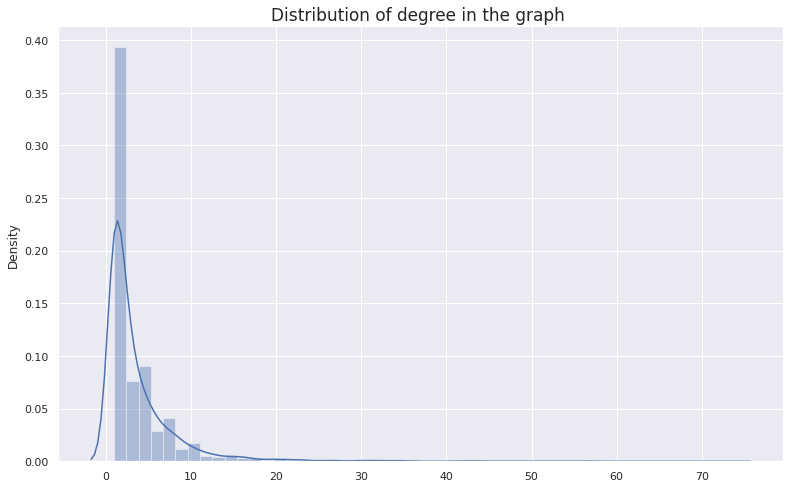

In [ ]:
visualization1(graph)

## Visualization 2 - visualize the best users

In order to give a feeling of the importance of the selected user, we are simply going to visualize its position in the graph (in red), along with a subset of its closest nodes. In detail, we are going to select up to ten of the immediate neighbors of the given node, and for each of them up to five of its neighbors. This means that, in the worst case, we will visualize $5\times10 = 50 + 1 = 51 $ nodes, and the corresponding edges between them. We are going to discard the weight of the edge or the ID of the user for the sake of tidiness, since there is no particular need to identify the users in order to get a sense of the importance of the given user.

In [ ]:
def visualize_neighbors(graph, user):
    '''Draws a subgraph composed by the given user and a subset of its neighboring nodes.'''
    subset = []
    # take a subset of the neighbors of the user
    for neighbor in list(graph.neighbors(user))[:10]:
        subset.append(neighbor)
        # take also a subset of the neighbors of the neighbors
        for next_neigh in list(graph.neighbors(neighbor))[:5]:
            subset.append(next_neigh)
    # list of nodes that will be drawn
    to_draw = [user] + subset
    # select subgraph inside of bigger graph
    subgraph = graph.subgraph(to_draw)
    # color the user in red and all others in blue
    color_map = []
    for node in subgraph:
        if node == user:
            color_map.append('red')
        else: 
            color_map.append('blue')
    # set positions and draw
    pos = nx.spring_layout(subgraph, k = 1)
    nx.draw(subgraph, pos, node_color=color_map, edgecolors = 'black')

In [ ]:
def date_range(start, end, intv):
    '''Splits an interval of time into a given number of subintervals.'''
    from datetime import datetime
    start = datetime.strptime(start,"%d-%m-%Y")
    end = datetime.strptime(end,"%d-%m-%Y")
    diff = (end  - start ) / intv
    for i in range(intv):
        yield (start + diff * i).strftime("%d-%m-%Y")
    yield end.strftime("%d-%m-%Y")
    
def visualize_evolution(user, start, end, intv, metric):
    '''Visualises the evolution of the given centrality metric of the user over the given interval of time.'''
    metrics = [0]
    # splitting interval in smaller sections
    intervals = list(date_range(start, end, intv))
    # for each interval
    for i in range(len(intervals)-1):
        try:
            # computing the score 
            score = functionality2(user, intervals[i], intervals[i+1], metric)
        except:
            # if user not in subgraph, return 0
            score = 0
        # storing results
        metrics.append(score)
    # plotting
    plt.plot(intervals, metrics, color = 'blue')
    plt.title(f"Evolution of {metric.capitalize()} score over time", fontweight = 'bold', fontsize = 14)
    plt.xlabel('Time')
    plt.ylabel(f"{metric.capitalize()} score")
    plt.xticks(intervals,rotation = 45)
    plt.show()

In [ ]:
def visualization2(user, start, end, intv, metric):
    # create graph of given interval
    graph = create_graph(start, end)
    # visualize subgraph and metric evolution
    plt.figure(figsize = (14, 6))
    plt.subplot(1,2,1)
    plt.title('Subgraph visualization', fontweight = 'bold', fontsize = 14)
    visualize_neighbors(graph, user)
    plt.subplot(1,2,2)
    visualize_evolution(user, start, end, intv, metric)

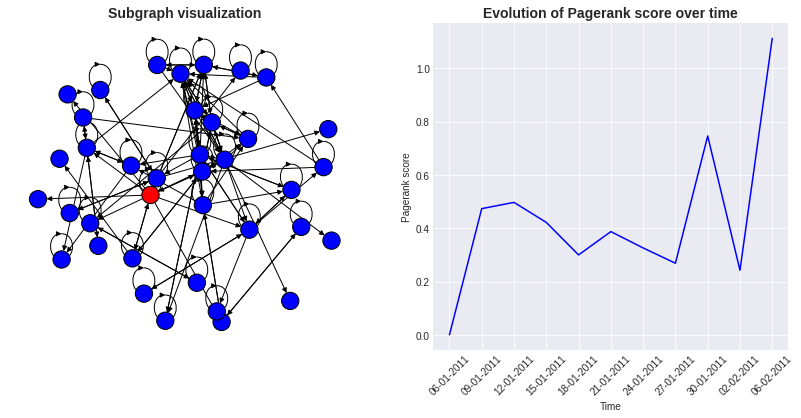

In [ ]:
visualization2(251738, '06-01-2011', '6-02-2011', 10, 'pagerank')

## Visualization 3 - Visualize the Shortest Ordered Route

In [ ]:
graph_2 = nx.subgraph(graph, [9,69742,244090,126950,3241,87971,164901,217403,91570,234440,9787,2548,78522,193939,18275,244358,243977,85514,1190,150358,19756,234435,18128,18770,
166921,155741,73070,234440,170249,243308,241923,244358,244359,244100,181310,237153,462307,244398,13895,14860,9021,244359,244073,241654,198729,
160823,161922,64082,89771,127404,31671,244150,228169,138475,18393,228936,9021])

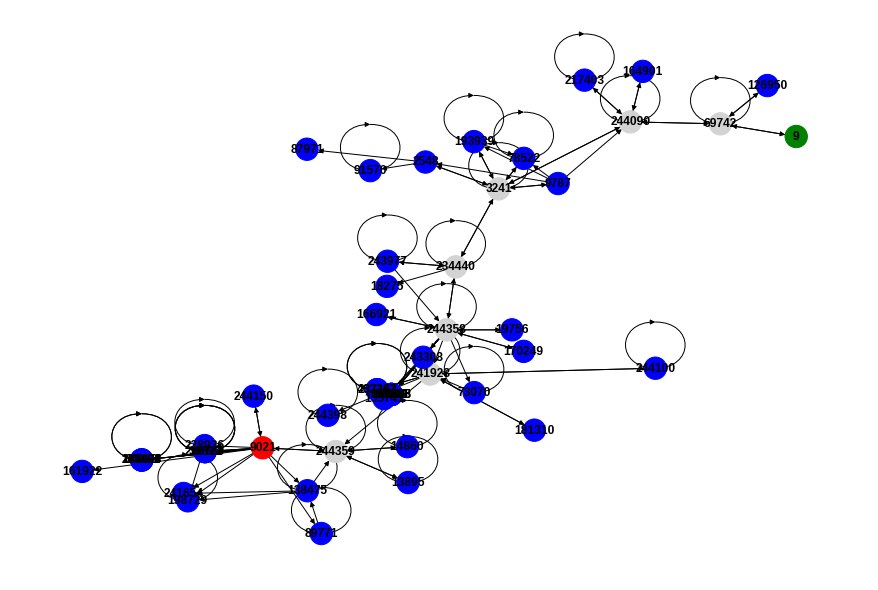

In [ ]:
figure(figsize=(12, 8))

color_map = []
for node in graph_2.nodes:
    if node in [69742, 244090, 3241, 234440, 244358, 241923, 244359]:
        color_map.append('lightgrey')
    elif node == 9: 
        color_map.append('green')  
    elif node == 9021:
        color_map.append('red')
    else:
        color_map.append('blue')
nx.draw_kamada_kawai(graph_2, with_labels=True, font_weight='bold', node_color=color_map, node_size=500)

plt.show()


## Visualization 4 - Visualize disconnecting graphs

Based on the approach that was used to implement the fourth functionality, we are going to visualize the process of disconnecting the two users by drawing the paths between them along which we have removed at least one edge. This means that the resulting graph just shows the shortest paths that were actually found first in the process of disconnecting the users. Notice that, for this reason, the resulting graph we are going to draw might give the feeling that a better choice could have been made in terms of removable edges in order to disconnect the two users. In reality, we are simply ignoring some of the longer paths between the two users that eventually pass along the removed links, that are therefore not visibile.

In [ ]:
def edges_from_paths(paths):
    edges = []
    for path in paths:
        for i in range(len(path)-1):
            edge = (path[i], path[i+1])
            edges.append(edge)
    return edges

In [ ]:
def visualization4(start1, end1, start2, end2, user1, user2):
    # merge graphs into one
    graph1 = create_graph(start1, end1)
    graph2 = create_graph(start2, end2)
    merged = merge_graphs(graph1, graph2)
    # create copy to preserve original graph
    merged_copy = merged.copy()
    # disconnect the two users
    removed, paths = disconnect(merged_copy, user1, user2)
    # creating a new graph out of removed links
    edges = edges_from_paths(paths)
    to_draw = nx.DiGraph(edges)
    # draw removed links
    color_map = []
    for edge in to_draw.edges():
        if edge in removed:
            color_map.append('red')
        else: 
            color_map.append('black')
    pos = nx.spring_layout(to_draw)
    plt.figure(figsize = (8, 8))
    plt.title('Removed links', fontweight = 'bold', fontsize = '16', color = 'red')
    pos = nx.spring_layout(to_draw, k = 1)
    labels = {user1 : 'User 1', user2 : 'User 2'}
    nx.draw(to_draw, pos, with_labels=True, labels = labels, edge_color = color_map, node_color = 'grey',
            edgecolors = 'black', font_weight = 'bold', font_size = 14, width = 4.0 , node_size = 2500)

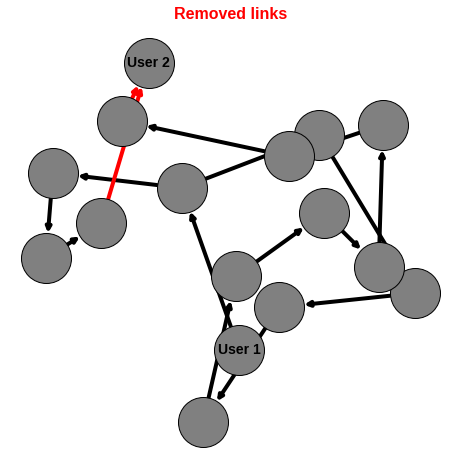

In [ ]:
visualization4('06-01-2011', '07-01-2011', '08-01-2011', '09-01-2011', 347716, 567098)

# 4. Algorithmic Question

In [15]:
def dorm_pair(n_kids,n_pairs):
    lelf_d={}
    right_d={}
    len_p=len(n_pairs)
    f_kids_num=[]
    for p in n_pairs:
        f_kids_num.append(p[0])
        f_kids_num.append(p[1])
    f_kids_num=list(set(f_kids_num))
    num_=0
    while(len(f_kids_num)>0):
        number_of_actions=0
        for i, p in enumerate(n_pairs):
            student1=p[0]
            student2=p[1]
            if not(student1 in lelf_d and student2 in right_d and student1 in right_d and student2 in lelf_d) and student1 in f_kids_num and student2 in f_kids_num:
                if number_of_actions==0:
                        lelf_d[student1]=0
                        right_d[student2]=0
                        f_kids_num.remove(student1)
                        f_kids_num.remove(student2)
                        n_pairs[i]=tuple((0,0))
                        number_of_actions+=1
            elif not(student2 in lelf_d and student1 in lelf_d) and student1 in right_d and student2 in f_kids_num:
                lelf_d[student2]=0
                f_kids_num.remove(student2)
                number_of_actions+=1
                n_pairs[i]=tuple((0,0))
            elif not(student2 in right_d and student1 in right_d) and student1 in lelf_d and student2 in f_kids_num:
                right_d[student2]=0
                f_kids_num.remove(student2)
                number_of_actions+=1
                n_pairs[i]=tuple((0,0))
            elif not(student1 in lelf_d and student2 in lelf_d) and student2 in right_d and student1 in f_kids_num:
                lelf_d[student1]=0
                f_kids_num.remove(student1)
                number_of_actions+=1
                n_pairs[i]=tuple((0,0))
            elif not(student1 in right_d and student2 in right_d) and student2 in lelf_d and student1 in f_kids_num:
                right_d[student1]=0
                f_kids_num.remove(student1)
                number_of_actions+=1 
                n_pairs[i]=tuple((0,0))
            elif student1 in lelf_d and student2 in right_d:
                number_of_actions+=1
                n_pairs[i]=tuple((0,0))
            elif student1 in right_d and student2 in lelf_d:
                number_of_actions+=1  
                n_pairs[i]=tuple((0,0))  
                num_+=number_of_actions
  
    lelf_d=[*lelf_d]
    right_d=[*right_d]
    if num_==len_p:
        lelf_d.extend([kid for kid in n_kids if kid not in lelf_d and kid not in right_d])  
        return lelf_d,right_d
    else:
        print("sorry, give me right numbers, in that case it is impossible to divide")
        return "Ops, not possible to divide"

In [3]:
def create_data(n,k):
    n_kids=[num+1 for num in range(n)]
    n_kids
    n_pairs=[]
    for i in range(k):
        kids=random.sample(n_kids, 2)
        n_pairs.append(tuple((kids[0],kids[1])))
    return(n_kids,n_pairs)

In [17]:
number_kids=int(input())
fighting_pairs=int(input())
n_kids,n_pairs=create_data(number_kids,fighting_pairs)
print("\nStudents:",n_kids,sep=" ")
print("\nFighting pairs:",n_pairs,sep=" ")

 12
 8



Students: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Fighting pairs: [(8, 11), (10, 9), (2, 6), (2, 1), (5, 2), (9, 7), (6, 9), (6, 11)]


In [18]:
l,r=dorm_pair(n_kids.copy(),n_pairs.copy())

In [19]:
print("\nLeft dorm students: ",l)
print("\nRight dorm students: ",r)


Left dorm students:  [8, 6, 10, 1, 5, 7, 3, 4, 12]

Right dorm students:  [11, 9, 2]
